In [43]:
#I found an Mnist distillation sample for Mnist and played with it.
#At the end of notebook i added my tests

In [1]:
import keras
from keras.datasets import mnist
from keras.layers import Activation, Input, Embedding, LSTM, Dense, Lambda, GaussianNoise, concatenate
from keras.models import Model
import numpy as np
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense #, Merge
from keras.optimizers import SGD, Adam, RMSprop
from keras.constraints import max_norm
from keras.layers import MaxPooling2D, Dropout, Dense, Flatten, Activation, Conv2D
from keras.models import Sequential
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# convert y_train and y_test to categorical binary values 
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
Y_train[0:2]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [5]:
# Reshape them to batch_size, width,height,#channels
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the values
X_train /= 255
X_test /= 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [6]:
#dump a sample data
" ".join([str(s) for s in set(X_train[0].flatten().tolist()) ] )

'0.0 0.0117647061124444 0.5333333611488342 0.07058823853731155 0.4941176474094391 0.686274528503418 0.10196078568696976 0.6509804129600525 1.0 0.9686274528503418 0.49803921580314636 0.11764705926179886 0.1411764770746231 0.3686274588108063 0.6039215922355652 0.6666666865348816 0.04313725605607033 0.054901961237192154 0.03529411926865578 0.8588235378265381 0.7764706015586853 0.7137255072593689 0.9450980424880981 0.3137255012989044 0.6117647290229797 0.41960784792900085 0.25882354378700256 0.32156863808631897 0.21960784494876862 0.8039215803146362 0.8666666746139526 0.8980392217636108 0.7882353067398071 0.5215686559677124 0.18039216101169586 0.30588236451148987 0.4470588266849518 0.3529411852359772 0.15294118225574493 0.6745098233222961 0.8823529481887817 0.9921568632125854 0.9490196108818054 0.7647058963775635 0.250980406999588 0.1921568661928177 0.9333333373069763 0.9843137264251709 0.7450980544090271 0.729411780834198 0.5882353186607361 0.5098039507865906 0.886274516582489 0.105882354

In [7]:
# Teacher model

input_shape = (28, 28, 1) # Input shape of each image

# Hyperparameters
nb_filters = 64 # number of convolutional filters to use
pool_size = (2, 2) # size of pooling area for max pooling
kernel_size = (3, 3) # convolution kernel size

teacher = Sequential()
teacher.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
teacher.add(Conv2D(64, (3, 3), activation='relu'))
teacher.add(MaxPooling2D(pool_size=(2, 2)))

teacher.add(Dropout(0.25)) # For reguralization

teacher.add(Flatten())
teacher.add(Dense(128, activation='relu'))
teacher.add(Dropout(0.5)) # For reguralization

teacher.add(Dense(nb_classes, name="last_dense"))
teacher.add(Activation('softmax')) # Note that we add a normal softmax layer to begin with

teacher.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

print(teacher.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [8]:
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model

student = Sequential()
student.add(Flatten(input_shape=input_shape))
student.add(Dense(32, activation='relu'))
student.add(Dropout(0.2))
student.add(Dense(nb_classes))
student.add(Activation('softmax'))

#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
student.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

student.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Train the teacher model as usual
epochs = 4
batch_size = 256
teacher.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 73s 1ms/step - loss: 0.3417 - accuracy: 0.8943 - val_loss: 0.0660 - val_accuracy: 0.9803
Epoch 2/4
60000/60000 [==============================] - 88s 1ms/step - loss: 0.1047 - accuracy: 0.9687 - val_loss: 0.0514 - val_accuracy: 0.9839
Epoch 3/4
60000/60000 [==============================] - 93s 2ms/step - loss: 0.0771 - accuracy: 0.9768 - val_loss: 0.0403 - val_accuracy: 0.9863
Epoch 4/4
60000/60000 [==============================] - 94s 2ms/step - loss: 0.0643 - accuracy: 0.9802 - val_loss: 0.0398 - val_accuracy: 0.9866


In [10]:
teacher.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [11]:
# Raise the temperature of teacher model and gather the soft targets

# Set a tempature value
temp = 7

#Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(teacher.input, teacher.get_layer('last_dense').output)

In [12]:
teacher_WO_Softmax.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179

In [13]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

In [14]:
type( "{:.2f}".format(0.12345))

str

In [15]:
def display_temperature(test_index):
    intermediate_output = teacher_WO_Softmax.predict(X_test[test_index].reshape(1,28,28,1))
    softmax_output = softmax(intermediate_output)
    print( " ".join( [ "{:.8f}".format(s) for s in softmax_output.flatten().tolist()  ]))
    pixels = X_test[test_index]
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels,cmap="gray")
    plt.show()
    
    # logits for the first number in test dataset
    #intermediate_output is 1,10 so infact data is at flattened list
    x = intermediate_output[0]
    print( " ".join( [ "{:.4f}".format(s) for s in x.flatten().tolist()  ]))
    plt.figure(figsize=(20, 10))
    temperature = [1,3,7,10,20,50]

    for temp in temperature:
        plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=2);
        plt.legend();
    plt.xlabel('classes ->');
    plt.ylabel('probability');
    plt.xlim([0, 10]);
    plt.show()

0.99999905 0.00000000 0.00000004 0.00000000 0.00000000 0.00000000 0.00000097 0.00000000 0.00000001 0.00000003


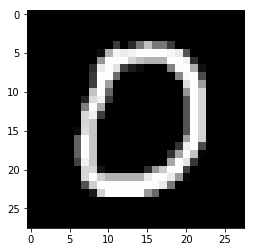

17.6277 -6.4842 0.6127 -10.1512 -5.1208 -5.7927 3.7822 -4.1701 -0.5921 0.3789


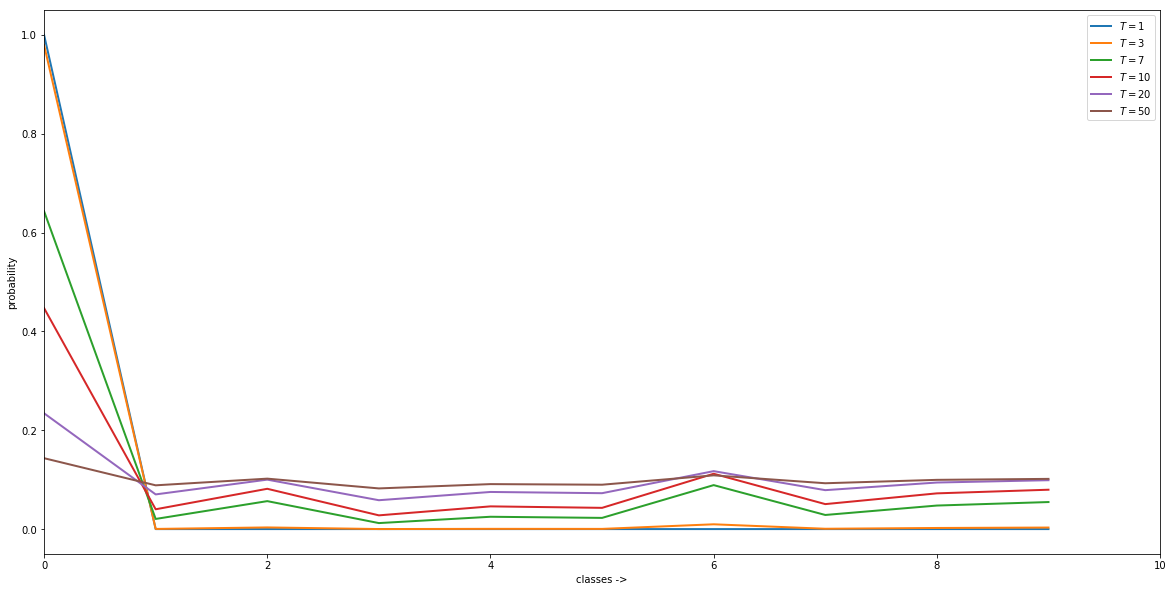

In [16]:
display_temperature(10)

0.00000001 0.00000001 0.00000014 0.00000049 0.00000001 0.00000000 0.00000000 0.99999887 0.00000000 0.00000045


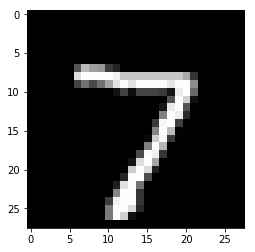

-2.5907 -3.1523 -0.0741 1.2130 -3.0272 -3.9232 -10.0720 15.7324 -3.4909 1.1180


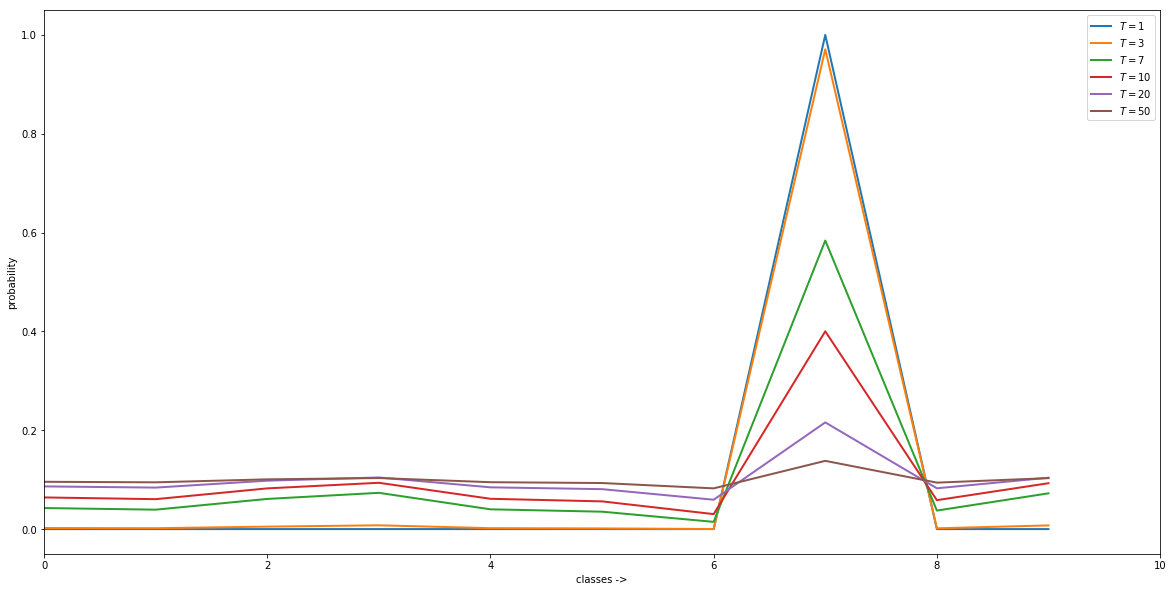

In [17]:
display_temperature(0)

In [18]:
temp

7

In [19]:
teacher_train_logits = teacher_WO_Softmax.predict(X_train)
teacher_test_logits = teacher_WO_Softmax.predict(X_test) # This model directly gives the logits ( see the teacher_WO_softmax model above)

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/temp
test_logits_T = teacher_test_logits / temp 

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate so that this becomes a 10 + 10 dimensional vector
Y_train_new = np.concatenate([Y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([Y_test, Y_test_soft], axis =1)

In [20]:
print(Y_train_new.shape )
print(Y_train_new[0] )

(60000, 20)
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 5.6744625e-07 8.0323008e-07 4.8539624e-07 3.8598864e-06 4.7245635e-07
 6.3363195e-06 9.9134377e-07 6.5100141e-07 9.8535486e-07 1.6626175e-06]


In [21]:
Y_test_new.shape

(10000, 20)

In [22]:
print(X_train.shape)
print(X_train[0].shape)

(60000, 28, 28, 1)
(28, 28, 1)


In [23]:
Y_train_new[0]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 5.6744625e-07, 8.0323008e-07,
       4.8539624e-07, 3.8598864e-06, 4.7245635e-07, 6.3363195e-06,
       9.9134377e-07, 6.5100141e-07, 9.8535486e-07, 1.6626175e-06],
      dtype=float32)

In [24]:
# Remove the softmax layer from the student network
student.layers.pop()

In [25]:
# Now collect the logits from the last layer
logits = student.layers[-1].output # This is going to be a tensor. And hence it needs to pass through a Activation layer
probs = Activation('softmax')(logits)

In [26]:
# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = Activation('softmax')(logits_T)

In [27]:
output = concatenate([probs, probs_T])
# This is our new student model
student = Model(student.input, output)

In [28]:
student.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
flatten_2_input (InputLayer)    (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           flatten_2_input[0][0]            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           25120       flatten_2[0][0]                  
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 32)           0           dense_2[0][0]                    
____________________________________________________________________________________________

In [29]:
# This will be a teacher trained student model. 
# --> This uses a knowledge distillation loss function

# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = alpha*logloss(y_true,y_pred) + logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

student.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc] )

In [30]:
print(X_train.shape)
print(Y_train_new.shape)

(60000, 28, 28, 1)
(60000, 20)


In [31]:
Y_train_new[0]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 5.6744625e-07, 8.0323008e-07,
       4.8539624e-07, 3.8598864e-06, 4.7245635e-07, 6.3363195e-06,
       9.9134377e-07, 6.5100141e-07, 9.8535486e-07, 1.6626175e-06],
      dtype=float32)

In [32]:
print("X_test",X_test.shape)
print("Y_test_new",Y_test_new.shape)

X_test (10000, 28, 28, 1)
Y_test_new (10000, 20)


In [33]:
student.fit(X_train, Y_train_new,
          batch_size=256,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test_new))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 1s 14us/step - loss: 0.2113 - acc: 0.4320 - val_loss: 0.1864 - val_acc: 0.6946
Epoch 2/4
60000/60000 [==============================] - 1s 11us/step - loss: 0.1836 - acc: 0.6875 - val_loss: 0.1734 - val_acc: 0.7930
Epoch 3/4
60000/60000 [==============================] - 1s 11us/step - loss: 0.1752 - acc: 0.7575 - val_loss: 0.1690 - val_acc: 0.8096
Epoch 4/4
60000/60000 [==============================] - 1s 11us/step - loss: 0.1721 - acc: 0.7766 - val_loss: 0.1672 - val_acc: 0.8181


In [34]:
# This is a standalone student model (same number of layers as original student model) trained on same data
# for comparing it with teacher trained student.

n_student = Sequential()
n_student.add(Flatten(input_shape=input_shape))
n_student.add(Dense(32, activation='relu'))
n_student.add(Dropout(0.2))
n_student.add(Dense(nb_classes))
n_student.add(Activation('softmax'))

#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
n_student.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [35]:
n_student.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                25120     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [36]:
n_student.fit(X_train, Y_train,
          batch_size=256,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 1s 12us/step - loss: 0.6800 - accuracy: 0.7991 - val_loss: 0.3068 - val_accuracy: 0.9139
Epoch 2/4
60000/60000 [==============================] - 1s 10us/step - loss: 0.3766 - accuracy: 0.8884 - val_loss: 0.2547 - val_accuracy: 0.9274
Epoch 3/4
60000/60000 [==============================] - 1s 11us/step - loss: 0.3198 - accuracy: 0.9055 - val_loss: 0.2166 - val_accuracy: 0.9369
Epoch 4/4
60000/60000 [==============================] - 1s 11us/step - loss: 0.2885 - accuracy: 0.9139 - val_loss: 0.1960 - val_accuracy: 0.9414


In [37]:
n_predicted = n_student.predict(X_test)
n_predicted_results = [ np.argmax(npred) for npred in n_predicted]

In [38]:
predicted = student.predict(X_test)
predicted_results = [ np.argmax(npred) for npred in predicted]

In [39]:
cnt = -1
for index,(y_actual ,y_predicted) in enumerate( zip(y_test,n_predicted_results)):
    if y_actual != y_predicted:
        cnt += 1
        print("index :", index , " actual ->" ,y_actual , "  predicted -> ", y_predicted)
print(cnt)

index : 8  actual -> 5   predicted ->  6
index : 33  actual -> 4   predicted ->  6
index : 38  actual -> 2   predicted ->  3
index : 92  actual -> 9   predicted ->  4
index : 124  actual -> 7   predicted ->  4
index : 149  actual -> 2   predicted ->  4
index : 151  actual -> 9   predicted ->  8
index : 217  actual -> 6   predicted ->  5
index : 241  actual -> 9   predicted ->  8
index : 247  actual -> 4   predicted ->  2
index : 259  actual -> 6   predicted ->  0
index : 290  actual -> 8   predicted ->  4
index : 300  actual -> 4   predicted ->  6
index : 320  actual -> 9   predicted ->  1
index : 321  actual -> 2   predicted ->  7
index : 340  actual -> 5   predicted ->  3
index : 352  actual -> 5   predicted ->  0
index : 359  actual -> 9   predicted ->  4
index : 381  actual -> 3   predicted ->  7
index : 435  actual -> 8   predicted ->  7
index : 444  actual -> 2   predicted ->  8
index : 445  actual -> 6   predicted ->  0
index : 448  actual -> 9   predicted ->  8
index : 449  act

In [44]:
def display_temperature(model_scaled,test_index):
    intermediate_output = model_scaled.predict(X_test[test_index].reshape(1,28,28,1))
    softmax_output = softmax(intermediate_output)
    print( " ".join( [ "{:.8f}".format(s) for s in softmax_output.flatten().tolist()  ]))
    pixels = X_test[test_index]
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels,cmap="gray")
    plt.show()
    
    # logits for the first number in test dataset
    #intermediate_output is 1,10 so infact data is at flattened list
    x = intermediate_output[0]
    print( " ".join( [ "{:.4f}".format(s) for s in x.flatten().tolist()  ]))
    plt.figure(figsize=(20, 10))
    temperature = [1,3,7,10,20,50]

    for temp in temperature:
        plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=2);
        plt.legend();
    plt.xlabel('classes ->');
    plt.ylabel('probability');
    plt.xlim([0, 10]);
    plt.show()

0.08749633 0.08716892 0.08965623 0.08716887 0.08933067 0.09727012 0.20017897 0.08716851 0.08737018 0.08719122


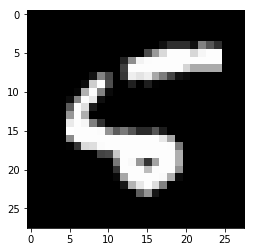

0.0038 0.0000 0.0281 0.0000 0.0245 0.1096 0.8314 0.0000 0.0023 0.0003


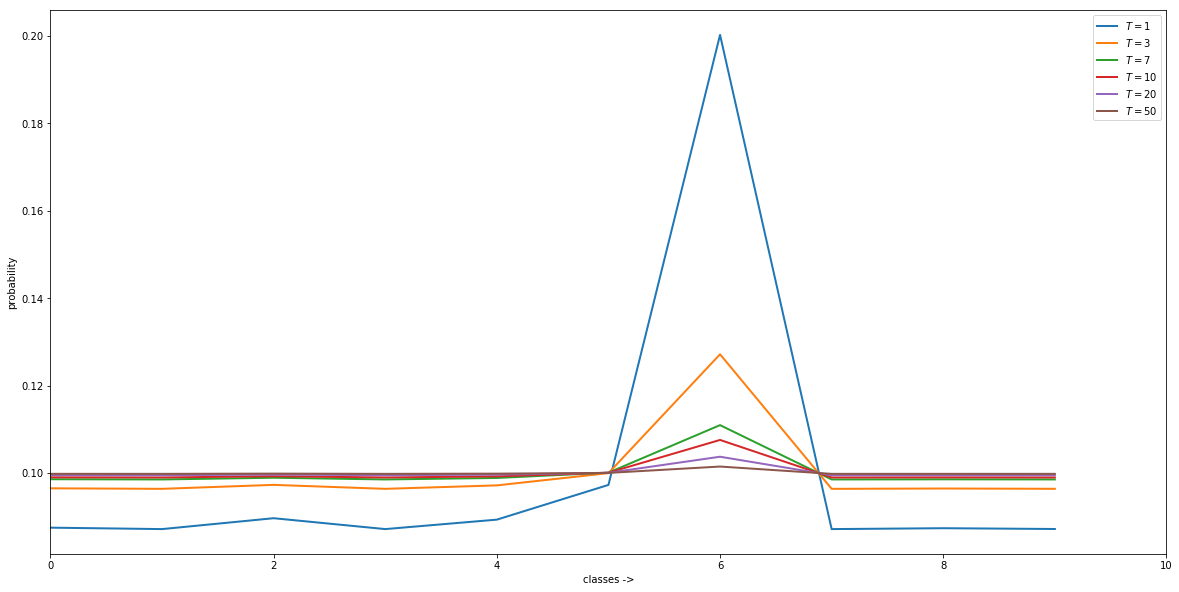

In [46]:
#index : 8  actual -> 5   predicted ->  6
display_temperature(n_student,8)

0.09036837 0.09256042 0.10694312 0.09388330 0.11542145 0.10361384 0.09562527 0.09130757 0.10164224 0.10863449


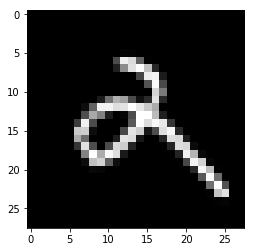

0.0019 0.0259 0.1703 0.0401 0.2466 0.1387 0.0585 0.0123 0.1195 0.1860


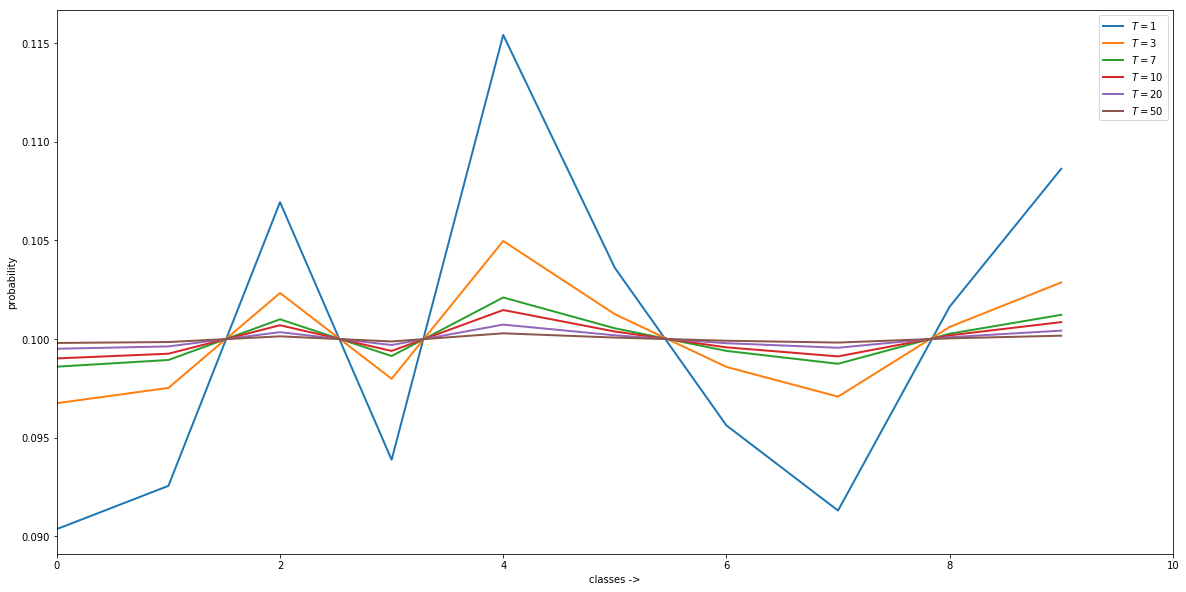

In [47]:
#index : 149  actual -> 2   predicted ->  9
display_temperature(n_student,149)
#here is it is good to see at temperature 3 guesses are becoming so close

0.08993731 0.10698035 0.09364554 0.09039281 0.12082871 0.09396704 0.13096838 0.09217520 0.09059767 0.09050695


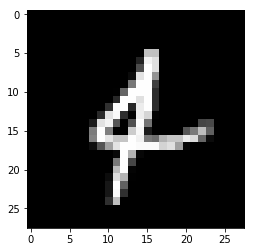

0.0028 0.1763 0.0432 0.0078 0.2980 0.0466 0.3786 0.0274 0.0101 0.0091


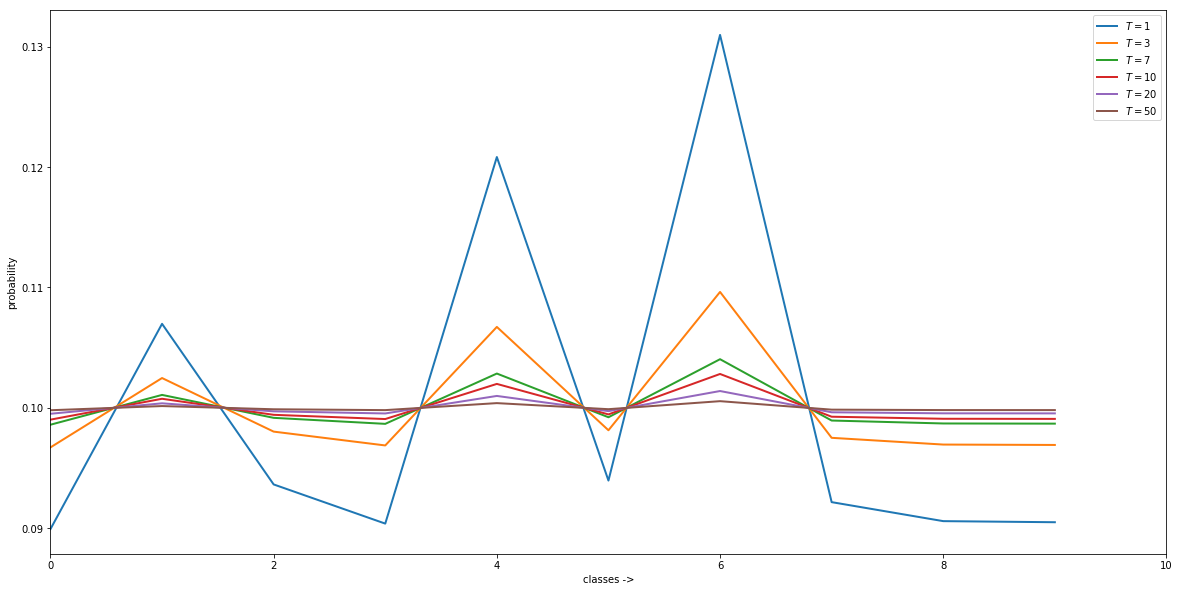

In [50]:
#index : 300  actual -> 4   predicted ->  6
display_temperature(n_student,300)
